In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import torch.optim as optim
import matplotlib.pyplot as plt
from copy import deepcopy
from PIL import Image
import csv
import pickle
from torchvision.datasets import CIFAR10
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns


In [2]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# # Data augmentation and transformation settings
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
# ])

# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
# ])




In [3]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, init_planes=64):
        super(ResNet, self).__init__()
        self.in_planes = init_planes

        self.conv1 = nn.Conv2d(3, init_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(init_planes)
        self.layer1 = self._make_layer(block, init_planes, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, init_planes * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, init_planes * 4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, init_planes * 8, num_blocks[3], stride=2)
        self.linear = nn.Linear(init_planes * 8 * block.expansion, num_classes)
        self.dropout = nn.Dropout(0.175)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear(out)
        return out

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, init_planes=64):
        super(ResNet, self).__init__()
        self.in_planes = init_planes

        self.conv1 = nn.Conv2d(3, init_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(init_planes)
        self.layer1 = self._make_layer(block, init_planes, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, init_planes * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, init_planes * 4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, init_planes * 8, num_blocks[3], stride=2)
        self.linear = nn.Linear(init_planes * 8 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [5]:
def ResNet18(num_classes=10, init_planes=64):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, init_planes=init_planes)

In [6]:
model = ResNet18(num_classes=10, init_planes=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
params_in_million = total_params / 1_000_000
print(f'Total Trainable Parameters: {params_in_million:.2f}M')


Total Trainable Parameters: 4.82M


In [8]:
def train_and_evaluate(model, train_loader, test_loader, epochs, optimizer, scheduler, criterion):
    best_accuracy = 0
    best_model = None

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == targets).sum().item()
                total += targets.size(0)

        test_loss /= len(test_loader)
        test_acc = 100 * correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_model = deepcopy(model.state_dict())
            torch.save(best_model, 'best_model_trained.pth')
            print(f"Saved better model with test accuracy: {best_accuracy:.2f}%")

        scheduler.step()

    return best_model, best_accuracy

In [9]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [10]:
transform_train_basic = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [11]:
trainset_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainset_basic = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_basic)

combined_trainset = ConcatDataset([trainset_augmented, trainset_basic])


100%|██████████| 170498071/170498071 [00:01<00:00, 92529263.58it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [12]:
trainloader = DataLoader(combined_trainset, batch_size=64, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified


In [13]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [14]:
model = ResNet18(num_classes=10, init_planes=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

best_model, best_accuracy = train_and_evaluate(model, trainloader, testloader, 80, optimizer, scheduler, criterion)
print(f"Best Test Accuracy: {best_accuracy:.2f}%")

Epoch 1: Train Loss: 1.2379, Train Acc: 55.41%, Test Loss: 0.8389, Test Acc: 70.15%
Saved better model with test accuracy: 70.15%
Epoch 2: Train Loss: 0.7477, Train Acc: 73.81%, Test Loss: 0.7079, Test Acc: 76.16%
Saved better model with test accuracy: 76.16%
Epoch 3: Train Loss: 0.5803, Train Acc: 79.84%, Test Loss: 0.5304, Test Acc: 82.34%
Saved better model with test accuracy: 82.34%
Epoch 4: Train Loss: 0.4788, Train Acc: 83.34%, Test Loss: 0.4311, Test Acc: 85.11%
Saved better model with test accuracy: 85.11%
Epoch 5: Train Loss: 0.4028, Train Acc: 86.03%, Test Loss: 0.4189, Test Acc: 86.33%
Saved better model with test accuracy: 86.33%
Epoch 6: Train Loss: 0.3489, Train Acc: 87.98%, Test Loss: 0.3904, Test Acc: 86.92%
Saved better model with test accuracy: 86.92%
Epoch 7: Train Loss: 0.3073, Train Acc: 89.31%, Test Loss: 0.3617, Test Acc: 88.18%
Saved better model with test accuracy: 88.18%
Epoch 8: Train Loss: 0.2734, Train Acc: 90.59%, Test Loss: 0.4120, Test Acc: 87.36%
Epoch 

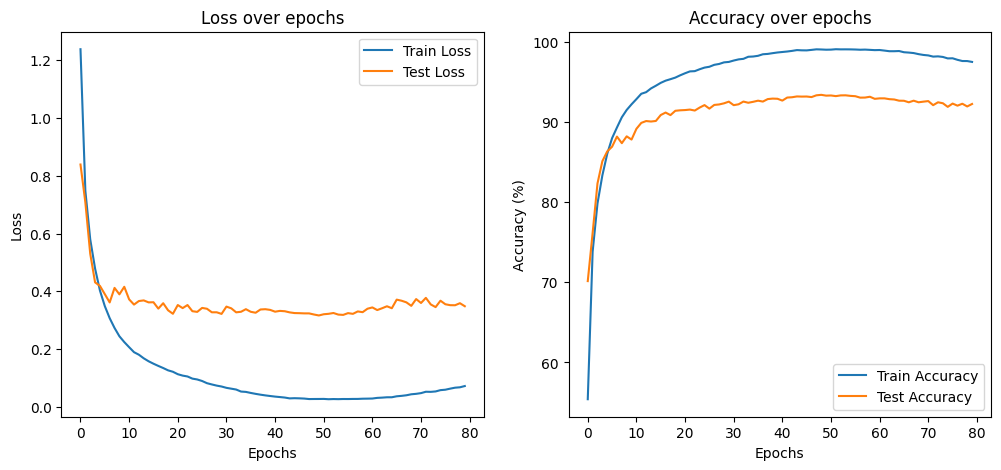

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

Files already downloaded and verified


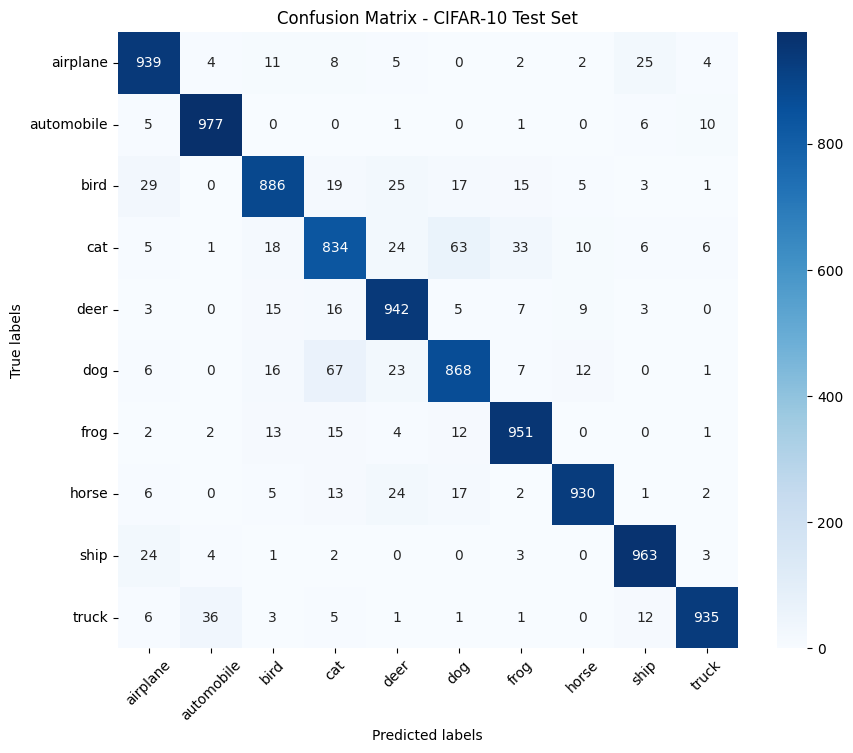

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

true_labels = []
predicted_labels = []

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - CIFAR-10 Test Set')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [20]:
file_path = '/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar_test_nolabels.pkl'

with open(file_path, 'rb') as file:
    test_images = pickle.load(file)

In [21]:
model = ResNet18(num_classes=10, init_planes=42)
model_state_dict = torch.load('best_model_trained.pth')
model.load_state_dict(model_state_dict)
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

predictions = []
for i in range(len(test_images[b'data'])):
    image_data = test_images[b'data'][i].reshape(3, 32, 32).transpose([1, 2, 0])
    image_data = transform(image_data).unsqueeze(0)  

    image_data = image_data.to(device)

    with torch.no_grad():
        output = model(image_data)
        _, predicted = torch.max(output, 1)
        predicted_label = predicted.item()
        predictions.append((test_images[b'ids'][i], predicted_label))

csv_file_path = 'predictions_85-K.csv'
with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['ID', 'Labels'])  
    for prediction in predictions:
        writer.writerow(prediction)

csv_file_path

'predictions_85-K.csv'